In [12]:
import sys
sys.path.append('../')
from src.my_classes import my_classes_l1, colors_classes_l1

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import os
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

In [14]:
l1_int = pd.read_csv("../csv/l1_int.csv")
#l2_int = pd.read_csv("../csv/l2_int.csv")

In [99]:
# add column to l1_int called name which corresponds to the value from my_classes_1 when the id is matched
l1_int['name'] = l1_int['class'].map(my_classes_l1)
print(l1_int.head(7))
# add a column color to l1_int which corresponds to the value from colors_classes_1 when the id is matched
l1_int['color'] = l1_int['class'].map(colors_classes_l1)
print(l1_int.head(7))
# turn nan to Other in the name column
l1_int['name'] = l1_int['name'].fillna('Other')
print(l1_int.head(7))

  class  int                                               name    color
0     E    1  Prairies, terrains domines par des especes non...  #789262
1     F    2                        Landes, fourres et toundras  #ff4500
2     G    3             Bois, forets et autres habitats boises  #006400
3     I    4  Habitats agricoles, horticoles et domestiques ...  #00ff00
4     J    5  Zones baties, sites industriels et autres habi...  #555555
5     Z    6                                                NaN      NaN
  class  int                                               name    color
0     E    1  Prairies, terrains domines par des especes non...  #789262
1     F    2                        Landes, fourres et toundras  #ff4500
2     G    3             Bois, forets et autres habitats boises  #006400
3     I    4  Habitats agricoles, horticoles et domestiques ...  #00ff00
4     J    5  Zones baties, sites industriels et autres habi...  #555555
5     Z    6                                       

In [45]:
my_colors_map = l1_int.set_index('int')['color'].to_dict()

In [96]:
my_colors_map[6] = '#8a2be2'
print(my_colors_map)

{1: '#789262', 2: '#ff4500', 3: '#006400', 4: '#00ff00', 5: '#555555', 6: '#8a2be2'}


In [18]:
#img name img_zone1_0_0_patch_1_12.tif
# msk name msk_zone1_0_0_patch_1_12.tif

class EcomedDataset(Dataset):
    def __init__(self, img_dir, msk_dir, level):
        self.img_dir = img_dir
        self.msk_dir = msk_dir
        self.level = level
        self.imgs = list(img_dir.rglob('*.tif'))
        self.msks = self.imgs.copy()
        for i, img_path in enumerate(self.imgs):
            # get the before last part of the path
            zone = img_path.parts[-2] 
            img_name = img_path.name
            msk_name = img_name.replace('img', 'msk')
            msk_path = msk_dir / zone / msk_name
            self.msks[i] = msk_path
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]
        with rasterio.open(img_path) as src:
            img = src.read()
        with rasterio.open(msk_path) as src:
            msk = src.read(self.level)
        img = img.astype(np.int16)
        return img, msk

In [76]:
def plot_img_msk(img_list, msk_list, my_colors_map):
    cmap_l1 = ListedColormap([my_colors_map[k] for k in sorted(my_colors_map.keys())])
    num_images = len(img_list)
    fig, axes = plt.subplots(num_images, 2, figsize=(5,20))
    for i in range(0, num_images):
        img = img_list[i]
        msk = msk_list[i]
        
        img = img[:3]  # Supprimer le canal IR
        p2, p98 = np.percentile(img, (2, 98), axis=(1, 2))
        img = np.clip((img - p2[:, None, None]) / (p98[:, None, None] - p2[:, None, None]), 0, 1)
        
        axes[i, 0].imshow(img.permute(1, 2, 0))
        im = axes[i, 1].imshow(msk, cmap=cmap_l1)        
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')    
    plt.tight_layout()
    plt.show()

In [55]:
settings_dict = {
    'patch_size': 256, 
    'level': 1, 
    'bs': 32,#32 
    'shuffle': 'random', 
}
img_path = Path(f'../data/patch{settings_dict["patch_size"]}/img/')
msk_path = Path(f'../data/patch{settings_dict["patch_size"]}/msk/l123/')

In [21]:
# Create a dataloader for level 1
dataset = EcomedDataset(img_path, msk_path, settings_dict['level'])
dataloader = DataLoader(dataset, batch_size=settings_dict['bs'], shuffle=True)

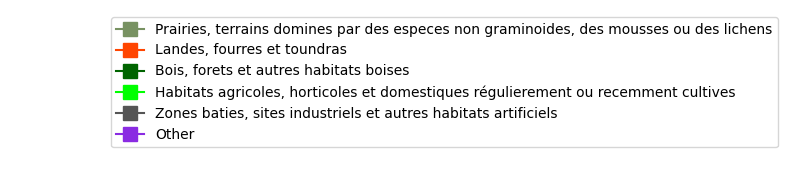

In [101]:
plt.figure(figsize=(10, 2))
color_square_size = 10
# Plot color squares for each class in the legend
for c in range(1, len(my_colors_map)+1):
    plt.plot([], [], color=my_colors_map[c], marker='s', markersize=color_square_size,
                label=l1_int[l1_int['int'] == c]['name'].values[0])

plt.legend()
plt.axis('off')
plt.box(False)
plt.show()

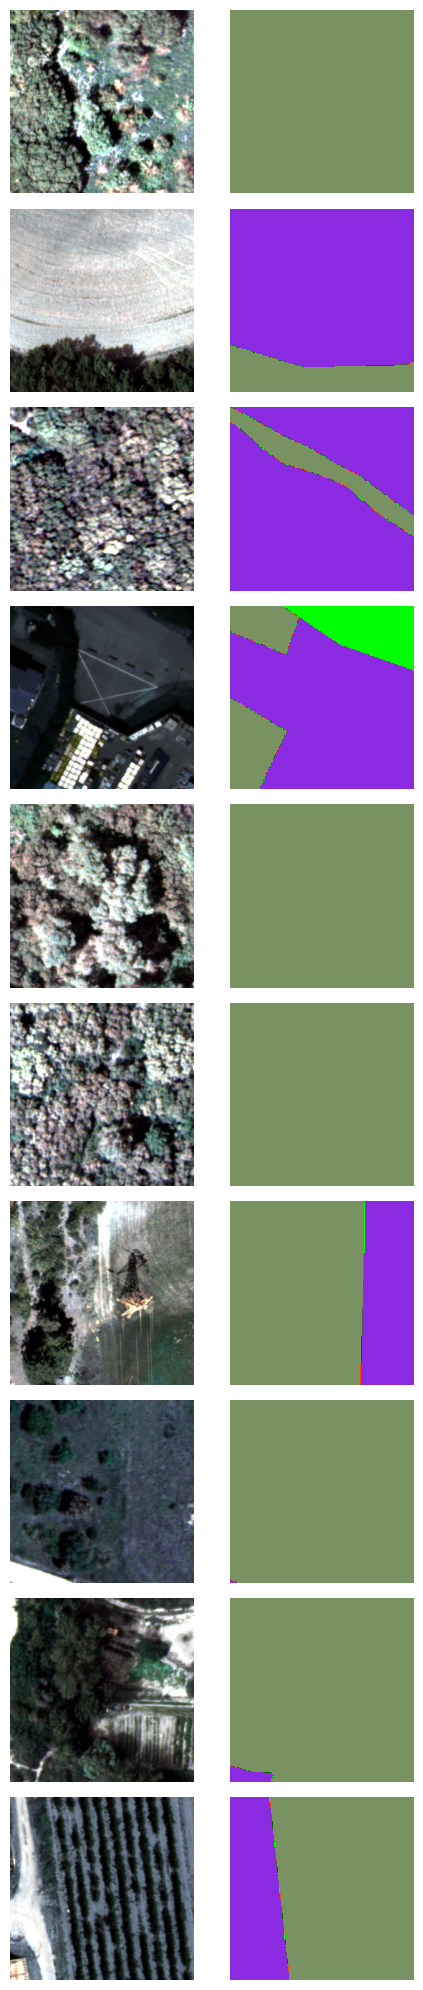

In [77]:
# plot 50 images and masks
for i, (img, msk) in enumerate(dataloader):
    plot_img_msk(img[:10], msk[:10], my_colors_map)
    break

/home/bertille/miniconda3/envs/ecomed_venv/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


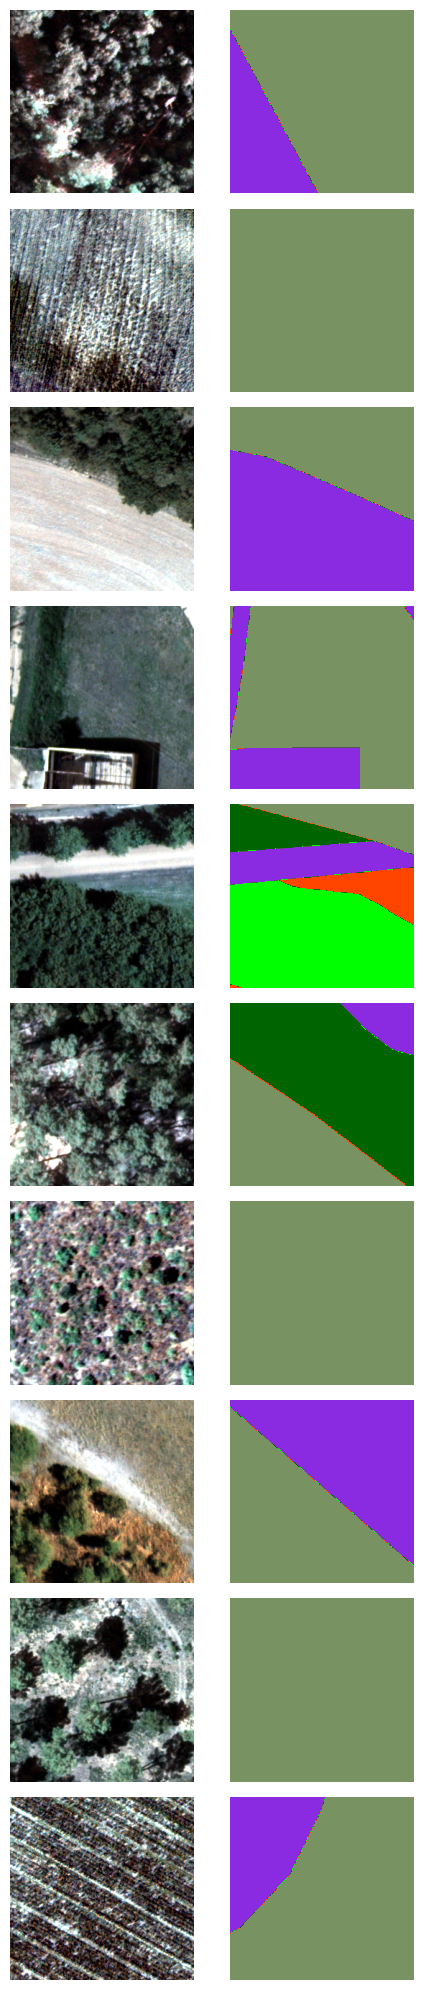

In [102]:
# plot 50 images and masks
for i, (img, msk) in enumerate(dataloader):
    plot_img_msk(img[10:20], msk[10:20], my_colors_map)
    break

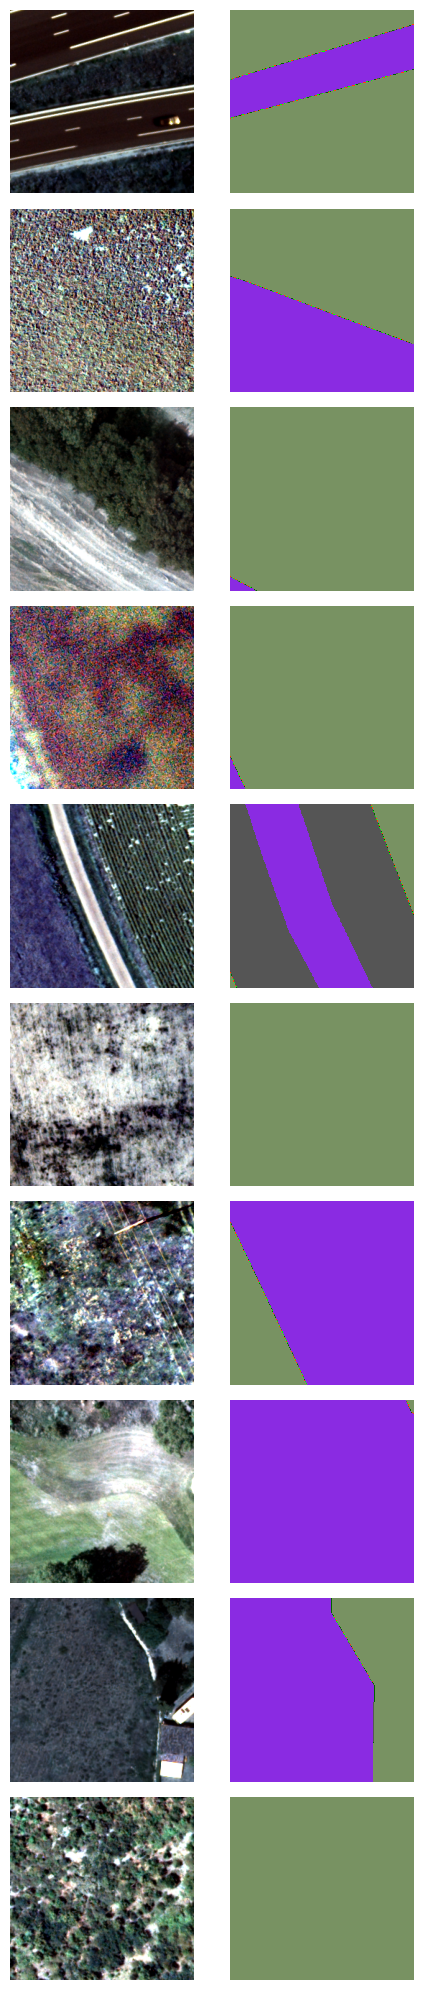

In [103]:
# plot 50 images and masks
for i, (img, msk) in enumerate(dataloader):
    plot_img_msk(img[20:30], msk[20:30], my_colors_map)
    break